**Chapter 2 – End-to-end Machine Learning project**

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

What's the problem/purpose for doing this?
We will use the outputs to see if it's a good place to invest

Think these before going ahead:
Is it supervised, unsupervised, or Reinforcement Learning?
Is it a classification task, a regression task, or something else?
Should you use batch learning or online learning techniques?

It is supervised because we have labels
Regression because continuous numerical value. Not categorizing or classifying like binary
Multivariate regression because many features
Batch learning because we are not providing any continuous data. We already have a dataset and that is enough

Root Mean Square Error (RMSE) - It measures the standard deviation of the errors the system makes in its predictions

REMEMBER:
For supervised learning tasks, identify the target attribute(s)
Visualize the data
Study the correlations between attributes  
Study how you would solve the problem manually
Identify the promising transformations you may want to apply
These are important steps to think about before starting

# Get the Data

In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

house = load_housing_data()

## Data Structure

In [4]:
house.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
house["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [7]:
house.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Create a Test Set

In [8]:
# BEFORE StratifiedShuffleSplit, creating an extra column called income_cat to make sure train/test sets have representative income distributions
# We need income categories because StratifiedShuffleSplit requires categorical data (not continuous)
import numpy as np
house["income_cat"] = pd.cut(house["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
# Checking categories
house["income_cat"].value_counts().sort_index()

,count
income_cat,
1,822
2,6581
3,7236
4,3639
5,2362


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(house, house["income_cat"]):
    strat_train_set = house.loc[train_index]
    strat_test_set = house.loc[test_index]

# final train/test variables
train_set = strat_train_set
test_set = strat_test_set
print(f"Training set: {len(train_set)} samples")
print(f"Test set: {len(test_set)} samples")

# Removing the helper column
for set_ in (train_set, test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# working only with the  only with training data from now on
house= train_set.copy()

Training set: 16512 samples
Test set: 4128 samples


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

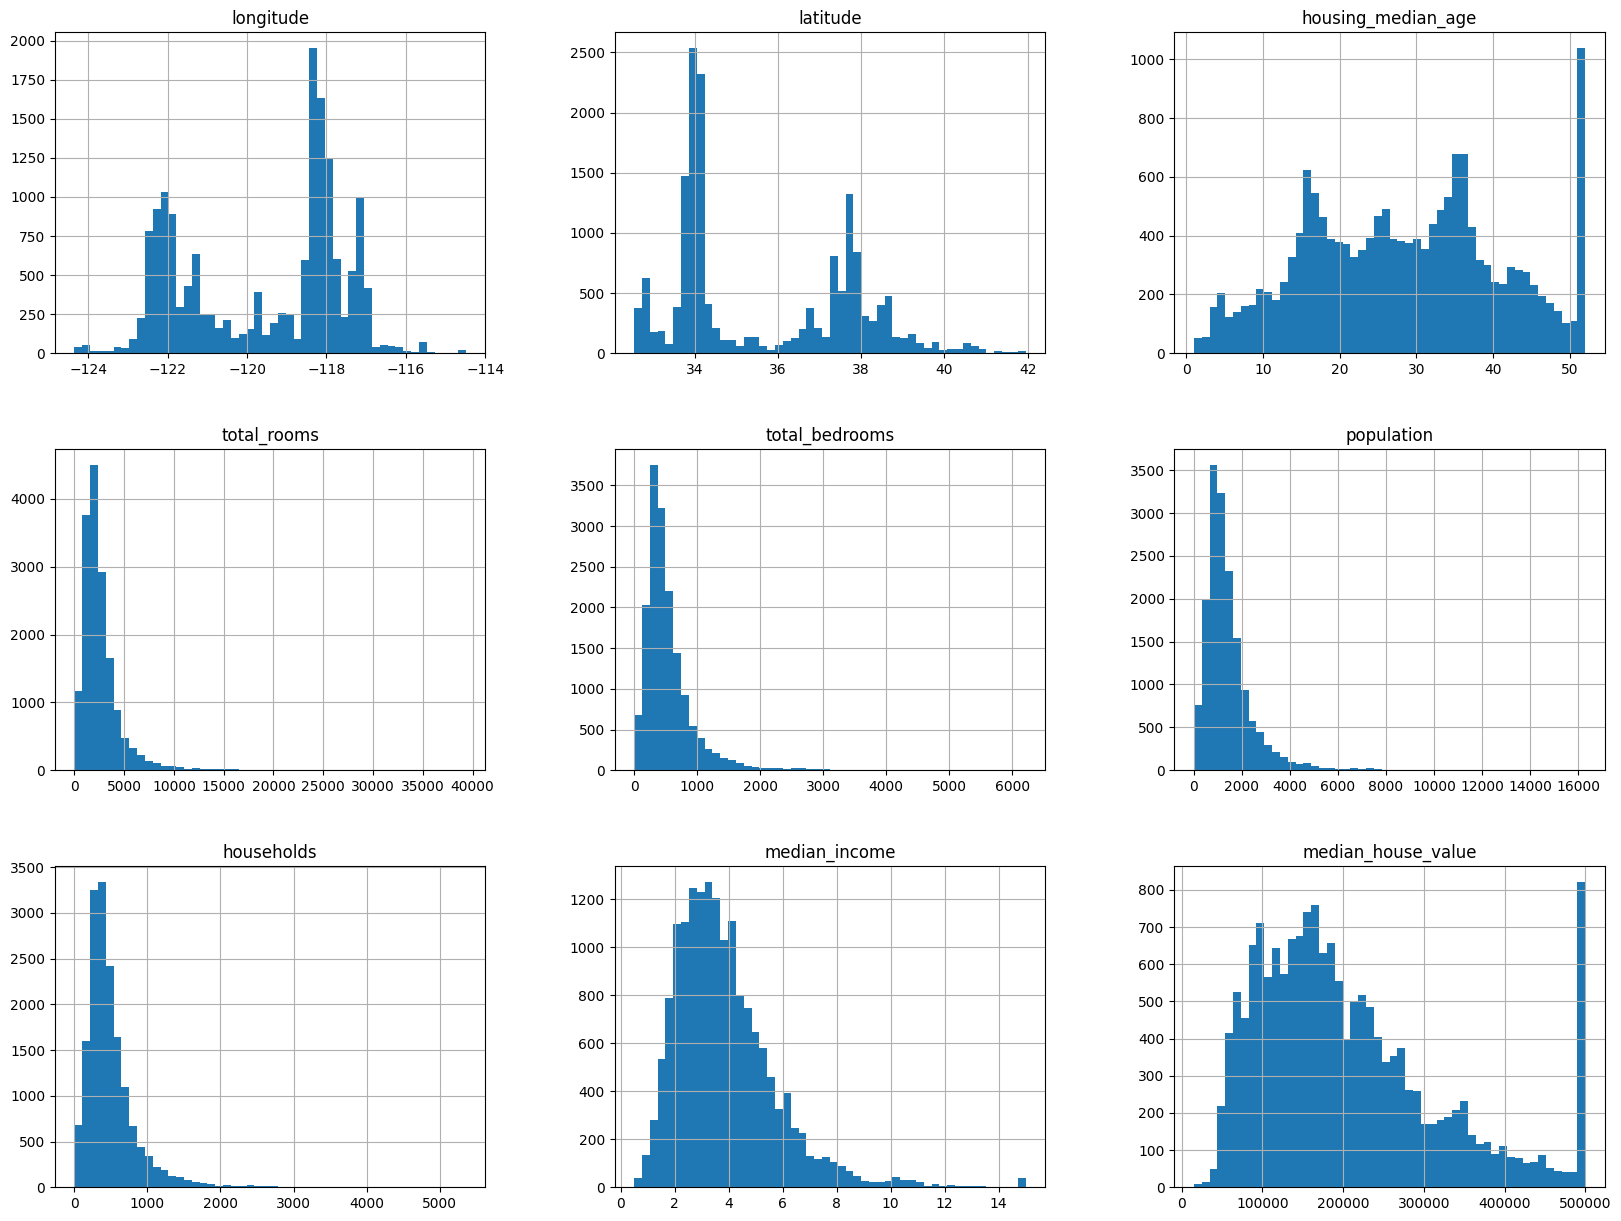

In [10]:
house.hist(bins=50, figsize=(20,15))

## Visualizing Geographical Data

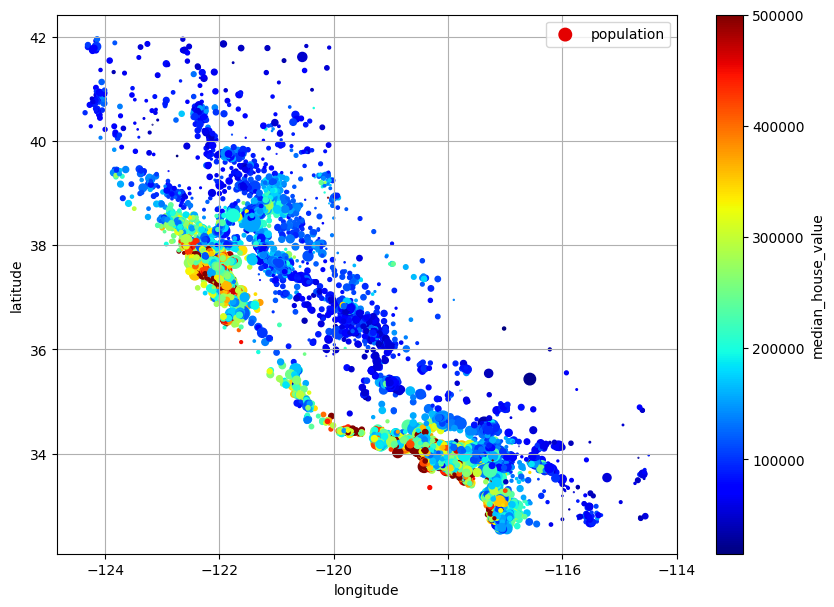

In [11]:
import matplotlib.pyplot as plt
house.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=house["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

## Corr matrices

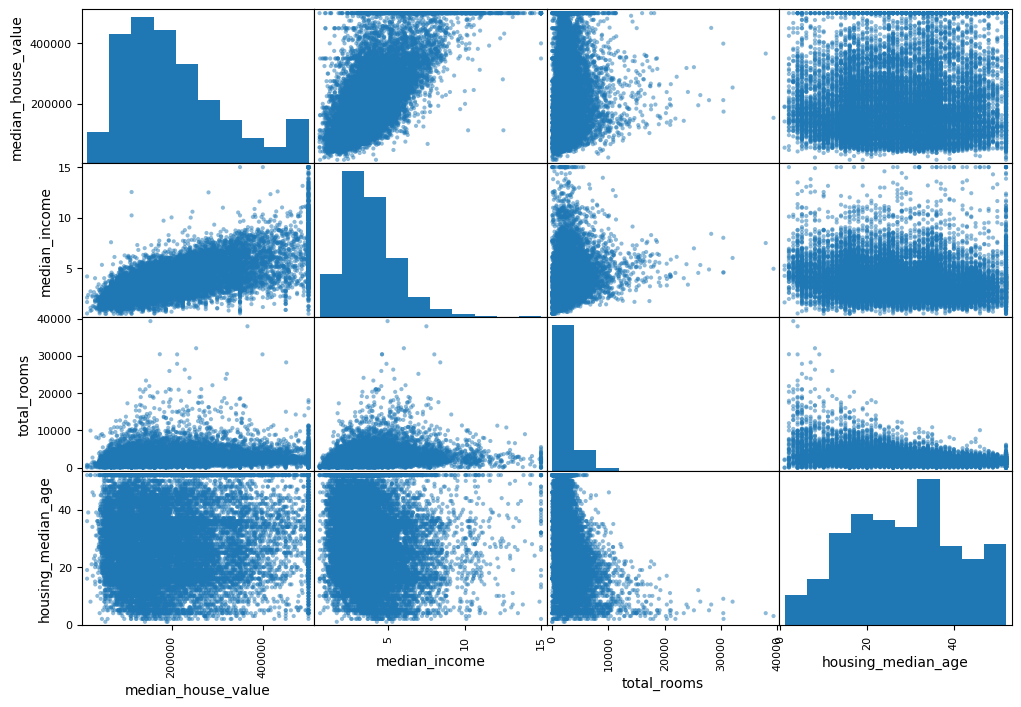

In [12]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(house[attributes], figsize=(12, 8))
plt.show()


<Axes: xlabel='median_income', ylabel='median_house_value'>

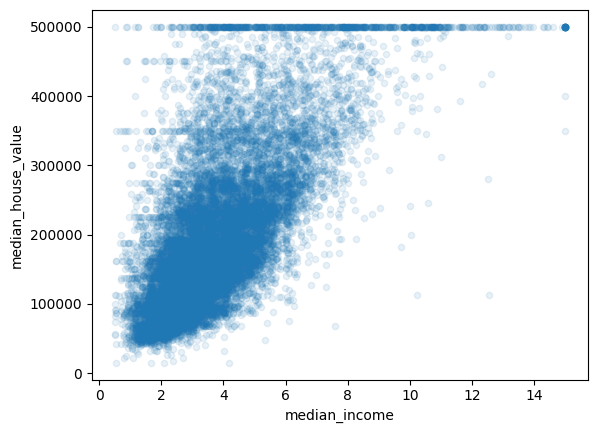

In [13]:
house.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

In [14]:
print("All numerical columns:")
numerical_cols = house.select_dtypes(include=[np.number]).columns.tolist()
print(numerical_cols)

All numerical columns:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']


In [15]:
numerical_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

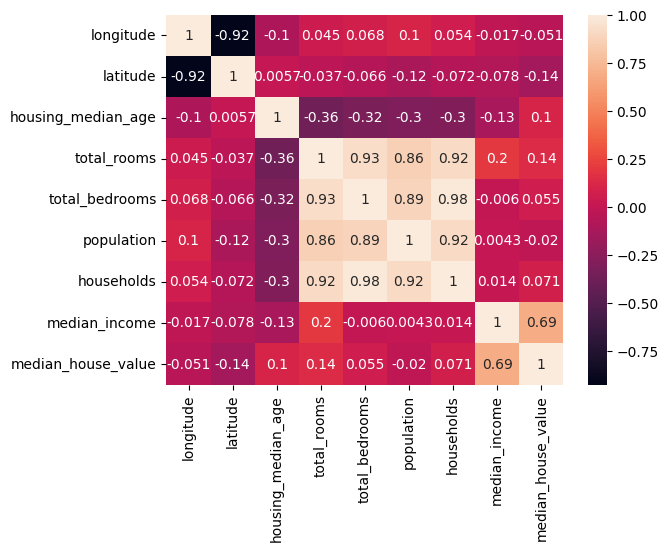

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = house[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Prepare the Data for Machine Learning Algorithms


Feature Engineering : Creating new features (Columns) out of our raw data using domain knowledge.
Imputation : Inserting values where they might be missing
Encoding categorical Variables : Transforming some categorical varibales into numerical variables
Scaling : Applying a scalar that transforms all our data on the same numerical scale.

In [17]:
house_features = train_set.drop("median_house_value", axis=1)
house_labels = train_set["median_house_value"].copy()

## Data Cleaning

In [18]:
print(house_features.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64


In [19]:
from sklearn.impute import SimpleImputer

In [20]:
house_num = house_features.drop("ocean_proximity", axis=1)

In [21]:
imputer = SimpleImputer(strategy="median")

In [22]:
imputer.fit(house_num)

SimpleImputer(strategy='median')

In [23]:
X = imputer.transform(house_num)
housing_tr = pd.DataFrame(X, columns=house_num.columns, index=house_num.index)

In [24]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [25]:
housing_tr.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0


## Handling Text and Categorical Attributes

In [26]:
housing_cat = house_features[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [27]:
#using onehot encoder

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat)

print("Shape:", housing_cat_1hot.shape)
print("Categories:", encoder.categories_)
print("First 5 rows:")
print(housing_cat_1hot[:5].toarray())

Shape: (16512, 5)
Categories: [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
First 5 rows:
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


## Feature Scaling

In [28]:
# Check the ranges of your numerical data
housing_tr.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.573125,35.637746,28.577156,2639.402798,537.881298,1425.513929,499.990189,3.870428
std,2.000624,2.133294,12.585738,2185.287466,421.831667,1094.795467,382.865787,1.891936
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.000000,297.000000,787.000000,279.000000,2.562500
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1167.000000,408.000000,3.538500
75%,-118.010000,37.720000,37.000000,3154.000000,642.000000,1726.000000,603.000000,4.750000
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
housing_num_scaled = scaler.fit_transform(housing_tr)

print("Original data shape:", housing_tr.shape)
print("Scaled data shape:", housing_num_scaled.shape)
print("Scaled data sample:")
print(housing_num_scaled[:5])

Original data shape: (16512, 8)
Scaled data shape: (16512, 8)
Scaled data sample:
[[-1.42303652  1.0136059   1.86111875  0.31191221  1.36816703  0.13746004
   1.39481249 -0.93649149]
 [ 0.59639445 -0.702103    0.90762971 -0.30861991 -0.43592476 -0.69377062
  -0.37348471  1.17194198]
 [-1.2030985   1.27611874  0.35142777 -0.71224036 -0.76070869 -0.78876841
  -0.77572662 -0.75978881]
 [ 1.23121557 -0.88492444 -0.91989094  0.70226169  0.74230601  0.38317548
   0.73137454 -0.85028088]
 [ 0.71136206 -0.87554898  0.58980003  0.79012465  1.59575285  0.44437597
   1.75526303 -0.18036472]]


In [30]:
import numpy as np

# Convert sparse matrix to dense array
housing_cat_dense = housing_cat_1hot.toarray()

# Combine numerical and categorical
housing_prepared = np.concatenate([housing_num_scaled, housing_cat_dense], axis=1)

print("Numerical data shape:", housing_num_scaled.shape)
print("Categorical data shape:", housing_cat_dense.shape)
print("Combined data shape:", housing_prepared.shape)
print("\nFirst row of combined data:")
print(housing_prepared[0])

Numerical data shape: (16512, 8)
Categorical data shape: (16512, 5)
Combined data shape: (16512, 13)

First row of combined data:
[-1.42303652  1.0136059   1.86111875  0.31191221  1.36816703  0.13746004
  1.39481249 -0.93649149  0.          0.          0.          1.
  0.        ]


## Training and Evaluating on the Training Set

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, house_labels)

# Make predictions
housing_predictions = lin_reg.predict(housing_prepared)

# Calculate error
lin_rmse = np.sqrt(mean_squared_error(house_labels, housing_predictions))
print("Linear Regression RMSE:", lin_rmse)

# Compare predictions vs actual
print("Predictions:", housing_predictions[:5])
print("Actual values:", house_labels.iloc[:5].values)

Linear Regression RMSE: 68232.83515124217
Predictions: [270886.93228264 334830.60618945 119856.18008898 109210.92995274
 305575.65811433]
Actual values: [458300. 483800. 101700.  96100. 361800.]


In [32]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Train Decision Tree
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, house_labels)

# Make predictions
housing_predictions = tree_reg.predict(housing_prepared)

# Calculate error
tree_mse = mean_squared_error(house_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Decision Tree RMSE:", tree_rmse)

Decision Tree RMSE: 0.0


## Better Evaluation Using Cross-Validation

In [33]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define display function (like textbook)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Cross-validation for Decision Tree
print("Decision Tree Cross-Validation")
tree_scores = cross_val_score(tree_reg, housing_prepared, house_labels,
                             scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

# Cross-validation for Linear Regression
print("Linear Regression Cross-Validation")
lin_scores = cross_val_score(lin_reg, housing_prepared, house_labels,
                           scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Decision Tree Cross-Validation
Scores: [67511.12157361 66602.08221589 67161.16154827 71823.01199989
 69588.48344133 68403.52629336 73116.1021791  69906.43119396
 68821.82229867 66082.22530079]
Mean: 68901.5968044853
Standard deviation: 2150.1587190808
Linear Regression Cross-Validation
Scores: [69823.93458835 67748.84358734 67256.04927007 69050.18214272
 67334.60772112 68688.9649581  67424.75877757 69952.42288885
 67537.81218643 68344.1931601 ]
Mean: 68316.17692806528
Standard deviation: 971.537305247095


In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Train Random Forest
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, house_labels)

# Training RMSE (will be low due to overfitting)
forest_predictions = forest_reg.predict(housing_prepared)
forest_train_rmse = np.sqrt(mean_squared_error(house_labels, forest_predictions))
print("Random Forest Training RMSE:", forest_train_rmse)

# Cross-validation RMSE (more realistic)
print("\n=== Random Forest Cross-Validation ===")
forest_scores = cross_val_score(forest_reg, housing_prepared, house_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Random Forest Training RMSE: 18057.976055305204

=== Random Forest Cross-Validation ===
Scores: [48484.96959165 50000.16612239 47505.35064619 49316.09714579
 48428.76921481 49128.82161789 48456.75463566 49460.26983712
 48874.68869078 49358.24455204]
Mean: 48901.41320543065
Standard deviation: 670.5367015311969


# Fine-Tune Your Model

In [36]:
# trying gridsearch

from sklearn.model_selection import GridSearchCV

# Try a broader parameter grid
param_grid = [
    {'n_estimators': [100, 200], 'max_features': [6, 8]}
]
# Create Random Forest
forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                          scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, house_labels)

# Get best parameters
print("Best parameters:", grid_search.best_params_)
print("Best score:", np.sqrt(-grid_search.best_score_))

Best parameters: {'max_features': 6, 'n_estimators': 200}
Best score: 49323.073909931256


Analyze the Best Models and Their Errors

In [37]:
# Get feature importances
feature_importances = grid_search.best_estimator_.feature_importances_

#
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_attribs = ["<1H OCEAN", "INLAND", "ISLAND", "NEAR BAY", "NEAR OCEAN"]

attributes = num_attribs + extra_attribs + cat_attribs

# Display importance ranking
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.415477402785462), 'median_income'),
 (np.float64(0.146637854651831), 'pop_per_hhold'),
 (np.float64(0.12044789492738467), 'longitude'),
 (np.float64(0.10889056500447392), 'latitude'),
 (np.float64(0.046558473090745026), 'housing_median_age'),
 (np.float64(0.04287138531693044), 'population'),
 (np.float64(0.03561602458991176), 'total_rooms'),
 (np.float64(0.030145090112079474), 'total_bedrooms'),
 (np.float64(0.0280292325983971), 'households'),
 (np.float64(0.01512207275097262), 'rooms_per_hhold'),
 (np.float64(0.006553256500334999), 'INLAND'),
 (np.float64(0.0033305226155797623), '<1H OCEAN'),
 (np.float64(0.0003202250558971373), 'bedrooms_per_room')]

In [39]:
# Get the best model
final_model = grid_search.best_estimator_

# Prepare test set
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Transform numerical data
housing_num_test = X_test.drop("ocean_proximity", axis=1)
X_test_imputed = imputer.transform(housing_num_test)
X_test_scaled = scaler.transform(X_test_imputed)

# Transform categorical data
housing_cat_test = X_test[["ocean_proximity"]]
X_test_cat_encoded = encoder.transform(housing_cat_test).toarray()

# Combine numerical and categorical
X_test_prepared = np.concatenate([X_test_scaled, X_test_cat_encoded], axis=1)

# Final evaluation
final_predictions = final_model.predict(X_test_prepared)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f"Final Test RMSE: {final_rmse}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Final Test RMSE: 48816.569684343
